In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load Data and Features
df = pd.read_csv('../data/processed/features_complete.csv')

feature_columns = [
    'grid_position',
    'avg_finish_last_3',
    'avg_finish_last_5',
    'avg_finish_at_circuit',
    'constructor_avg_finish',
    'points_before_race'
]

target_column = 'finish_position'

print(f"Data loaded: {len(df)} rows")
print(f"Features: {feature_columns}")
print(f"Target: {target_column}")

Data loaded: 10494 rows
Features: ['grid_position', 'avg_finish_last_3', 'avg_finish_last_5', 'avg_finish_at_circuit', 'constructor_avg_finish', 'points_before_race']
Target: finish_position


In [4]:
# Create Temporal Split
train_df = df[df['year'] <= 2015].copy()
val_df = df[(df['year'] >= 2016) & (df['year'] <= 2018)].copy()
test_df = df[df['year'] >= 2019].copy()

print(f"Train: {len(train_df)} rows ({train_df['year'].min()}-{train_df['year'].max()})")
print(f"Val: {len(val_df)} rows ({val_df['year'].min()}-{val_df['year'].max()})")
print(f"Test: {len(test_df)} rows ({test_df['year'].min()}-{test_df['year'].max()})")

Train: 6663 rows (1994-2015)
Val: 1275 rows (2016-2018)
Test: 2556 rows (2019-2024)


In [5]:
# Prepare Feature Matrices
X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_val = val_df[feature_columns]
y_val = val_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6663, 6)
X_val shape: (1275, 6)
X_test shape: (2556, 6)


In [6]:
# Baseline 1: Using feature Grid Position Only

print("BASELINE 1: GRID POSITION ONLY\n")

X_train_grid = X_train[['grid_position']]
X_val_grid = X_val[['grid_position']]

lr_grid = LinearRegression()
lr_grid.fit(X_train_grid, y_train)

y_val_pred_grid = lr_grid.predict(X_val_grid)

mae_grid = mean_absolute_error(y_val, y_val_pred_grid)
rmse_grid = np.sqrt(mean_squared_error(y_val, y_val_pred_grid))
r2_grid = r2_score(y_val, y_val_pred_grid)

print(f"MAE: {mae_grid:.3f}")
print(f"RMSE: {rmse_grid:.3f}")
print(f"R²: {r2_grid:.3f}")

BASELINE 1: GRID POSITION ONLY

MAE: 3.865
RMSE: 4.786
R²: 0.363


In [7]:
# Baseline 2: Linear Regression (All Features)


# Use Baseline 1 as the reference and generate a new model: same Linear Regression, but with all the features.
# Baseline 1 uses only grid position, but this model will use all 6 features already present in (X_train, y_train)
print("BASELINE 2: LINEAR REGRESSION (ALL FEATURES)\n")


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)


mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
r2_lr = r2_score(y_val, y_val_pred_lr)


# Print results
print(f"MAE: {mae_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²: {r2_lr:.3f}")


# Calculate improvement over Baseline 1 (grid-only)
mae_reduction = mae_grid - mae_lr
mae_reduction_pct = (mae_reduction / mae_grid) * 100
r2_improvement = r2_lr - r2_grid


# Print the improvement
print("\nImprovement over grid-only:")
print(f"MAE reduction: {mae_reduction:.3f} ({mae_reduction_pct:.1f}%)")
print(f"R² improvement: {r2_improvement:.3f}")






# Baseline 2, continued: Logistic Regression (All Features, Categorical Target)
print("\nBASELINE 2: LOGISTIC REGRESSION (ALL FEATURES)\n")


# Convert finish_position to a categorical target: Podium (1–3) vs Non-podium (4+)
y_train_cat = (y_train <= 3).astype(int)
y_val_cat = (y_val <= 3).astype(int)


# The Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train_cat)
y_val_pred_logreg = logreg.predict(X_val)


accuracy_logreg = accuracy_score(y_val_cat, y_val_pred_logreg)
f1_logreg = f1_score(y_val_cat, y_val_pred_logreg)
cm_logreg = confusion_matrix(y_val_cat, y_val_pred_logreg)


# Print classification metrics for podium prediction
print(f"Accuracy: {accuracy_logreg:.3f}  # % of drivers correctly classified")
print(f"F1-score: {f1_logreg:.3f} # Balance of precision and recall for podium finishes")


print("Confusion Matrix:")
print(cm_logreg)



BASELINE 2: LINEAR REGRESSION (ALL FEATURES)

MAE: 3.622
RMSE: 4.605
R²: 0.411

Improvement over grid-only:
MAE reduction: 0.243 (6.3%)
R² improvement: 0.047

BASELINE 2: LOGISTIC REGRESSION (ALL FEATURES)

Accuracy: 0.901  # % of drivers correctly classified
F1-score: 0.658 # Balance of precision and recall for podium finishes
Confusion Matrix:
[[1028   61]
 [  65  121]]



Linear Regression Coefficients:
                  feature  coefficient
0           grid_position     0.350710
4  constructor_avg_finish     0.280986
2       avg_finish_last_5     0.133499
3   avg_finish_at_circuit     0.054637
5      points_before_race    -0.031121
1       avg_finish_last_3    -0.007964


<Figure size 1000x600 with 0 Axes>

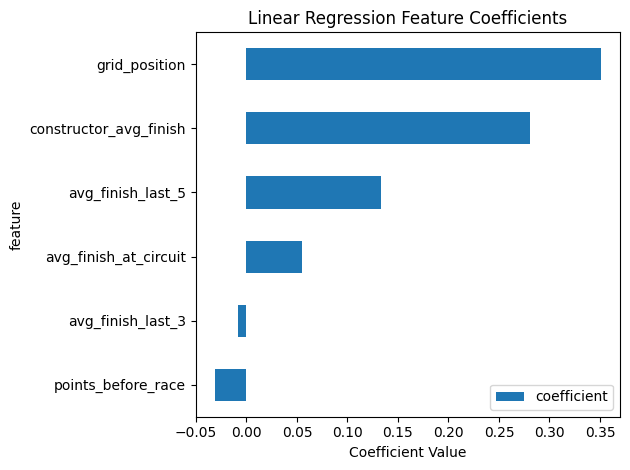

In [ ]:
# Feature Coefficients (Linear Regression)
print("\nLinear Regression Coefficients:")
coef_df = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
coef_df.sort_values('coefficient').plot(x='feature', y='coefficient', kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Feature Coefficients')
plt.tight_layout()
plt.show()

In [ ]:
# Model 2: Random Forest

print("MODEL 2: RANDOM FOREST\n")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
r2_rf = r2_score(y_val, y_val_pred_rf)

print(f"MAE: {mae_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²: {r2_rf:.3f}")


MODEL 2: RANDOM FOREST

MAE: 3.726
RMSE: 4.694
R²: 0.387

Improvement over Linear Regression:
MAE reduction: -0.104 (-2.9%)
R² improvement: -0.023



Random Forest Feature Importances:
                  feature  importance
0           grid_position    0.573221
4  constructor_avg_finish    0.217114
2       avg_finish_last_5    0.071756
1       avg_finish_last_3    0.061770
3   avg_finish_at_circuit    0.055327
5      points_before_race    0.020812


<Figure size 1000x600 with 0 Axes>

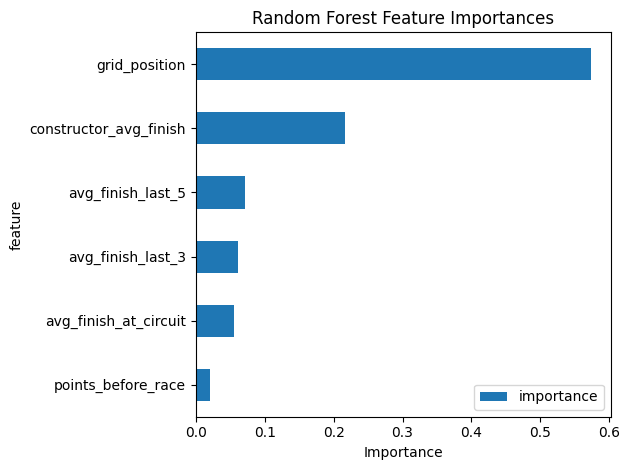

In [ ]:
# Feature Importance (Random Forest)
print("\nRandom Forest Feature Importances:")
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
importance_df.sort_values('importance').plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()

plt.show()

In [ ]:
# Model 3: XGBoost

print("MODEL 3: XGBOOST\n")

xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_val_pred_xgb = xgb.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"MAE: {mae_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"R²: {r2_xgb:.3f}")

MODEL 3: XGBOOST

MAE: 3.760
RMSE: 4.793
R²: 0.361

Improvement over Linear Regression:
MAE reduction: -0.139 (-3.8%)
R² improvement: -0.049



XGBoost Feature Importances:
                  feature  importance
0           grid_position    0.402747
4  constructor_avg_finish    0.238392
2       avg_finish_last_5    0.099942
5      points_before_race    0.089044
3   avg_finish_at_circuit    0.086238
1       avg_finish_last_3    0.083636


<Figure size 1000x600 with 0 Axes>

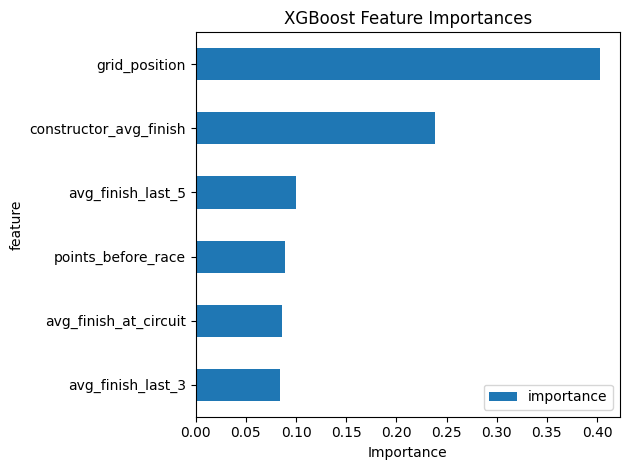

In [ ]:
# Feature Importance (XGBoost)
print("\nXGBoost Feature Importances:")
xgb_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(xgb_importance_df)

plt.figure(figsize=(10, 6))
xgb_importance_df.sort_values('importance').plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
# Model Comparison

print("MODEL COMPARISON (VALIDATION SET)")

results = pd.DataFrame({
    'Model': ['Grid Only', 'Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_grid, mae_lr, mae_rf, mae_xgb],
    'RMSE': [rmse_grid, rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_grid, r2_lr, r2_rf, r2_xgb]
})

print(results.to_string(index=False))

# Define best_model_name 
best_model_idx = results['MAE'].idxmin()
best_model_name = results.loc[best_model_idx, 'Model']

print(f"\nBest performing model: {best_model_name}")


MODEL COMPARISON (VALIDATION SET)
            Model      MAE     RMSE       R²
        Grid Only 3.864908 4.786307 0.363120
Linear Regression 3.621553 4.604541 0.410574
    Random Forest 3.725983 4.694431 0.387336
          XGBoost 3.760184 4.793401 0.361231

Best performing model: Linear Regression


In [ ]:
# Summary

print("BASELINE MODELS SUMMARY")


print(f"\nBest Model: {best_model_name}")
print(f"  MAE: {results.loc[results['MAE'].idxmin(), 'MAE']:.3f} positions")
print(f"  RMSE: {results.loc[results['MAE'].idxmin(), 'RMSE']:.3f} positions")
print(f"  R²: {results.loc[results['MAE'].idxmin(), 'R²']:.3f}")

print(f"\nImprovement over grid-only baseline:")
best_mae = results.loc[results['MAE'].idxmin(), 'MAE']
print(f"  MAE reduction: {mae_grid - best_mae:.3f} ({(mae_grid - best_mae)/mae_grid*100:.1f}%)")
print(f"  R² improvement: {results.loc[results['MAE'].idxmin(), 'R²'] - r2_grid:.3f}")

BASELINE MODELS SUMMARY

Best Model: Linear Regression
  MAE: 3.622 positions
  RMSE: 4.605 positions
  R²: 0.411

Improvement over grid-only baseline:
  MAE reduction: 0.243 (6.3%)
  R² improvement: 0.047


### Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning - Random Forest

print("HYPERPARAMETER TUNING: RANDOM FOREST")

from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10]
}

rf_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(rf_tuned, param_grid_rf, cv=3, 
                               scoring='neg_mean_absolute_error', n_jobs=-1)

print("Tuning Random Forest...")
grid_search_rf.fit(X_train, y_train)

rf_best = grid_search_rf.best_estimator_
y_val_pred_rf_tuned = rf_best.predict(X_val)

mae_rf_tuned = mean_absolute_error(y_val, y_val_pred_rf_tuned)
r2_rf_tuned = r2_score(y_val, y_val_pred_rf_tuned)

print(f"Best params: {grid_search_rf.best_params_}")
print(f"MAE: {mae_rf_tuned:.3f}")
print(f"R²: {r2_rf_tuned:.3f}")
print(f"Improvement: {mae_rf - mae_rf_tuned:.3f} positions")

HYPERPARAMETER TUNING: RANDOM FOREST
Tuning Random Forest...


Best params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
MAE: 3.793
R²: 0.364
Improvement: -0.067 positions


In [ ]:
# Hyperparameter Tuning : XGBoost

print("HYPERPARAMETER TUNING: XGBOOST\n")


param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 9],
    'learning_rate': [0.05, 0.1]
}

xgb_tuned = XGBRegressor(random_state=42, n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb_tuned, param_grid_xgb, cv=3,
                                scoring='neg_mean_absolute_error', n_jobs=-1)

print("Tuning XGBoost...")
grid_search_xgb.fit(X_train, y_train)

xgb_best = grid_search_xgb.best_estimator_
y_val_pred_xgb_tuned = xgb_best.predict(X_val)

mae_xgb_tuned = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_val, y_val_pred_xgb_tuned)

print(f"Best params: {grid_search_xgb.best_params_}")
print(f"MAE: {mae_xgb_tuned:.3f}")
print(f"R²: {r2_xgb_tuned:.3f}")
print(f"Improvement: {mae_xgb - mae_xgb_tuned:.3f} positions")

HYPERPARAMETER TUNING: XGBOOST

Tuning XGBoost...
Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
MAE: 3.724
R²: 0.386
Improvement: 0.036 positions


### Stacking Ensemble method

In [ ]:
# Stacking Ensemble

print("STACKING ENSEMBLE\n")

from sklearn.ensemble import StackingRegressor

base_estimators = [
    ('lr', lr),
    ('rf', rf_best),
    ('xgb', xgb_best)
]

stacking_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=LinearRegression(),
    cv=3
)

stacking_model.fit(X_train, y_train)
y_val_pred_stack = stacking_model.predict(X_val)

mae_stack = mean_absolute_error(y_val, y_val_pred_stack)
r2_stack = r2_score(y_val, y_val_pred_stack)

print(f"MAE: {mae_stack:.3f}")
print(f"R²: {r2_stack:.3f}")

STACKING ENSEMBLE

MAE: 3.661
R²: 0.408


In [ ]:
# Final Comparison

print("FINAL MODEL COMPARISON\n")

results_final = pd.DataFrame({
    'Model': ['Grid Only', 'Linear Regression', 'Random Forest (Tuned)', 
              'XGBoost (Tuned)', 'Stacking'],
    'MAE': [mae_grid, mae_lr, mae_rf_tuned, mae_xgb_tuned, mae_stack],
    'R²': [r2_grid, r2_lr, r2_rf_tuned, r2_xgb_tuned, r2_stack]
})

print(results_final.to_string(index=False))

best_idx = results_final['MAE'].idxmin()
best_model_name = results_final.loc[best_idx, 'Model']
best_mae = results_final.loc[best_idx, 'MAE']
best_r2 = results_final.loc[best_idx, 'R²']

print(f"\nBest Model: {best_model_name}")
print(f"MAE: {best_mae:.3f} positions")
print(f"R²: {best_r2:.3f}")



FINAL MODEL COMPARISON

                Model      MAE       R²
            Grid Only 3.864908 0.363120
    Linear Regression 3.621553 0.410574
Random Forest (Tuned) 3.793400 0.363544
      XGBoost (Tuned) 3.723856 0.385749
             Stacking 3.661367 0.408173

Best Model: Linear Regression
MAE: 3.622 positions
R²: 0.411
Improvement over grid-only: 0.243 positions (6.3%)


In [ ]:
# Test Set Evaluation

print("TEST SET EVALUATION\n")

if best_model_name == 'Stacking':
    y_test_pred = stacking_model.predict(X_test)
elif best_model_name == 'XGBoost (Tuned)':
    y_test_pred = xgb_best.predict(X_test)
elif best_model_name == 'Random Forest (Tuned)':
    y_test_pred = rf_best.predict(X_test)
else:
    y_test_pred = lr.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Results ({best_model_name}):")
print(f"MAE: {mae_test:.3f} positions")
print(f"RMSE: {rmse_test:.3f} positions")
print(f"R²: {r2_test:.3f}")

TEST SET EVALUATION

Test Set Results (Linear Regression):
MAE: 3.320 positions
RMSE: 4.266 positions
R²: 0.453


In [ ]:
# Summary

print("PROJECT SUMMARY")

print(f"\nDataset: {len(df)} records (1994-2024)")
print(f"Features: {len(feature_columns)}")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

print(f"\nBest Model: {best_model_name}")
print(f"Validation MAE: {best_mae:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"Test R²: {r2_test:.3f}")


PROJECT SUMMARY

Dataset: 10494 records (1994-2024)
Features: 6
Train: 6663 | Val: 1275 | Test: 2556

Best Model: Linear Regression
Validation MAE: 3.622
Test MAE: 3.320
Test R²: 0.453


In [ ]:
# Demonstrate Predictions on 2024 Season

print("2024 RACE PREDICTIONS")


# Filter to 2024 races only
races_2024 = test_df[test_df['year'] == 2024].copy()

print(f"Total 2024 races in test set: {races_2024['raceId'].nunique()}")
print(f"Total driver entries: {len(races_2024)}")

# Get predictions
X_2024 = races_2024[feature_columns]
y_2024_actual = races_2024['finish_position']
y_2024_pred = lr.predict(X_2024)

# Add predictions to dataframe
races_2024['predicted_position'] = y_2024_pred

# Show sample predictions for one race
sample_race_id = races_2024['raceId'].iloc[0]
sample_race = races_2024[races_2024['raceId'] == sample_race_id].copy()
sample_race = sample_race.sort_values('predicted_position')

print(f"\nExample: Race {sample_race_id} Predictions")
print("-"*60)
print(f"{'Driver':<20} {'Grid':<6} {'Predicted':<10} {'Actual':<8}")
print("-"*60)

for idx, row in sample_race.head(10).iterrows():
    driver_name = row['surname'] if 'surname' in row else f"Driver {row['driverId']}"
    print(f"{driver_name:<20} {row['grid_position']:<6.0f} {row['predicted_position']:<10.1f} {row['finish_position']:<8.0f}")

print("-"*60)

# Show prediction accuracy for 2024
mae_2024 = mean_absolute_error(y_2024_actual, y_2024_pred)
print(f"\n2024 Season Prediction Accuracy: {mae_2024:.3f} MAE")

2024 RACE PREDICTIONS
Total 2024 races in test set: 24
Total driver entries: 479

Example: Race 1121 Predictions
------------------------------------------------------------
Driver               Grid   Predicted  Actual  
------------------------------------------------------------
Verstappen           1      4.0        1       
Leclerc              2      5.6        4       
Russell              3      6.8        5       
Sainz                4      8.5        3       
Pérez                5      8.8        2       
Piastri              8      9.3        8       
Norris               7      9.4        6       
Alonso               6      9.5        9       
Hamilton             9      10.1       7       
Stroll               12     10.8       10      
------------------------------------------------------------

2024 Season Prediction Accuracy: 2.925 MAE
